# Introduction
In the following sections of this notebook is presented the analysis made on the clustering models obtained thanks to the process illustrated in the notebook called *Clustering*.

Specifically the analysis performed is focused on present the configuration chosen as the best one in the creation of the model (and also present the results of the other models that has been trained).

For each model presented (two, one for a longer plot and one for a shorter one), is presented the evaluation of the model (with the presentation of the silhouette and the within-cluster sum of square distances), is performed a PCA to reduce the cluster components to 2 in order to make the clusters plottable.
Finally a scatter plot of the clustering model is presented.

Additionally the needed sample of the dataset in order to make the demo running are created.

# Needed Library Import
In this section the needed library are imported

In [ ]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=01eb294d987847bada959fabc7c3ddcf29dfacc742cea487e6b0b8e8fa50767a
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
!ngrok authtoken 2Tn9uykXlYRjLcSLIgmv1iLdEvG_3gqA9M3V4hLGqH9N3JWEr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


# PySpark Initialization
In this section the PySpark session is initialized

In [ ]:
from pyngrok import ngrok
import re
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=02f51e4134a3737f6a07033e3c76f2e829faaa94791be26c36b2619343bd0ecf
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as sqlf
from pyspark import SparkContext, SparkConf
from pyspark.ml.clustering import KMeans, KMeansModel
rom pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import HashingTF, CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("ClusteringAnalysis").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
port = '4050'
public_url = ngrok.connect(port).public_url

In [ ]:
print("To access the Spark Web UI console, please click on the following link to the ngrok tunnel \"{}\" -> \"http://127.0.0.1:{}\"".format(public_url, port))

To access the Spark Web UI console, please click on the following link to the ngrok tunnel "https://c79f-35-237-30-97.ngrok-free.app" -> "http://127.0.0.1:4050"


In [ ]:
spark

In [ ]:
# Connect this colab to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Utils
Notice that the detailed descriptions for the functions:

*   *clean_links*
*   *clean_punctuation*
*   *clean_extra_spaces*
*   *num_nonzeros*
*   *process_data_for_clustering*
*   *evaluate_k_means*

are provided in the notebook called *Clustering*

In [ ]:
def clean_links(raw_text):
  CLEANER_LINKS = re.compile('http[s]?://\S+')
  cleantext = re.sub(CLEANER_LINKS, '', raw_text)
  return cleantext

clean_links_UDF = sqlf.udf(lambda x : clean_links(x), StringType())

In [ ]:
def clean_punctuation(raw_text):
  CLEANER_PUNCTUATION = re.compile('[^\w\s]')
  cleantext = re.sub(CLEANER_PUNCTUATION, ' ', raw_text)
  return cleantext

clean_punctuation_UDF = sqlf.udf(lambda x : clean_punctuation(x), StringType())

In [ ]:
def clean_extra_spaces(raw_text):
  CLEANER_EXTRA_SPACES = re.compile('\s\s+')
  cleantext = re.sub(CLEANER_EXTRA_SPACES, ' ', raw_text)
  return cleantext

clean_extra_spaces_UDF = sqlf.udf(lambda x : clean_extra_spaces(x), StringType())

In [ ]:
@sqlf.udf("long")
def num_nonzeros(v):
  return v.numNonzeros()

In [ ]:
def process_data_for_clustering(dataset_df,
                                column_name):
  dataset_df = dataset_df.dropna()
  dataset_df = dataset_df.withColumn(column_name, clean_links_UDF(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, sqlf.trim(sqlf.col(column_name)))

  dataset_df = dataset_df.where(dataset_df.total_recommendations > 0)

  dataset_df = dataset_df.withColumn(column_name, sqlf.lower(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, clean_punctuation_UDF(sqlf.col(column_name)))
  dataset_df = dataset_df.withColumn(column_name, clean_extra_spaces_UDF(sqlf.col(column_name)))

  tokenizer = Tokenizer(inputCol=column_name, outputCol='tokens')
  tokens_df = tokenizer.transform(dataset_df)

  stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='terms')
  terms_df = stopwords_remover.transform(tokens_df)

  stemmer = SnowballStemmer(language="english")
  stemmer_udf = sqlf.udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
  terms_stemmed_df = terms_df.withColumn('terms_stemmed', stemmer_udf('terms'))

  cv = CountVectorizer(inputCol='terms_stemmed', outputCol="tf_features", vocabSize=1000, minDF=10)
  idf = IDF(inputCol="tf_features", outputCol="features")

  pipeline = Pipeline(stages=[cv, idf])
  features = pipeline.fit(terms_stemmed_df)
  tf_idf_df = features.transform(terms_stemmed_df)

  tf_idf_df = tf_idf_df.where(num_nonzeros("features") > 0)

  return tf_idf_df

In [ ]:
def evaluate_k_means(clusters,
                     metric_name="silhouette",
                     distance_measure="cosine",
                     prediction_col="cluster"
                     ):

  evaluator = ClusteringEvaluator(metricName=metric_name,
                                  distanceMeasure=distance_measure,
                                  predictionCol=prediction_col
                                  )

  return evaluator.evaluate(clusters)

In order to better analyze the clustering performances it has been chosen also to visualize them.

In order to do that the PCA on the computed features of the texts is computed

In [ ]:
def compute_PCA(dataset_df,
                input_col='features_norm',
                output_col='pca_features',
                num_components=2
                ):
  '''
  This function computes the PCA for the texts that will be clustered
  '''
  pca = PCA(k=num_components, inputCol=input_col, outputCol=output_col)
  pca_model = pca.fit(dataset_df)
  pca_result = pca_model.transform(dataset_df)
  return pca_result

The following function called *scatter_cluster* is used to plot a scatterplot based on the PCA computed in order to visualize the cluster shape.

The plot shows the two Principal Components computed earlier

In [ ]:
def scatter_cluster(pca_pd,
                    k,
                    n_col):
  '''
  This function plot a scatter plot that represent the cluster shape
  '''
  # The array colors is needed in order to have all different colors for the
  # cluster in the plo
  colors = np.random.rand(k, 3)

  # Transforms the array computed in the PCA into two different columns
  pca_pd[['pca_1', 'pca_2']] = pca_pd['pca_features'].apply(lambda x: pd.Series(x))
  plt.figure(figsize=(8, 6))
  # For each cluster computed
  for cluster_id in range(k):
    # Get the data of the PCA for that cluster
    cluster_data = pca_pd[pca_pd['cluster'] == cluster_id][['pca_1', 'pca_2']]
    # Create the scatter plot of the cluster
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f'Cluster {cluster_id}', color=colors[cluster_id])

  plt.title('TF-IDF KMeans Clustering')
  plt.xlabel('X')
  plt.ylabel('Y')
  # Needed to move the legend outside the plot
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=n_col)
  plt.show()

# Games clustered on 'about_the_game'
In this section the analysis made on the best clustering model on the texts contained in the column *about_the_game* is presented

In [ ]:
# Load data
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
# Pre-process it to create clusters
tf_idf_about_df = process_data_for_clustering(games_df, 'about_the_game')

In [ ]:
# Normalize the features because the cosine similarity will be used
tf_idf_about_df = Normalizer(inputCol='features', outputCol='features_norm', p=1).transform(tf_idf_about_df)

The best fitted model will then be load.

It is important to notice that in this case only a single model has been fitted due to the RAM limitations.

The evaluation metrics produced the following values

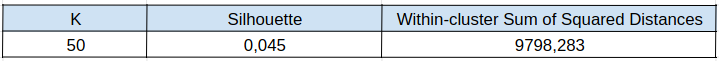

As it is possible to see from the Silhouette value, the model did not perform very well since it was not able to identify a clean separation among the different clusters

In [ ]:
# Load the best fitted model
cluster_about = KMeansModel.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/models/KMEANS_about_K_50')

In [ ]:
# Create the dataset with the cluster mapping
clusters_about_df = cluster_about.transform(tf_idf_about_df)

In [ ]:
# In order to free some RAM
del games_df
gc.collect()

524

In [ ]:
shilouette = evaluate_k_means(clusters_about_df)
print('The shilouette score, computed with the cosine distance, is: {:.3f}'.format(shilouette))

The shilouette score, computed with the cosine distance, is: 0.045


In [ ]:
# To inspect some the distribution of the elements in a sample of the clusters
clusters_about_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|  585|
|      1|  171|
|      2|  743|
|      3|  106|
|      4|  539|
|      5|  325|
|      6|  133|
|      7|  723|
|      8|   89|
|      9|  345|
|     10|  310|
|     11|   46|
|     12|   63|
|     13|  240|
|     14|  124|
|     15|  530|
|     16|  228|
|     17|  129|
|     18|  196|
|     19|  814|
+-------+-----+
only showing top 20 rows



In [ ]:
pca_df = compute_PCA(clusters_about_df)

In [ ]:
pca_pd = pca_df.toPandas()

As already anticipated form the Silhouette value the clusters are pretty much overlapped

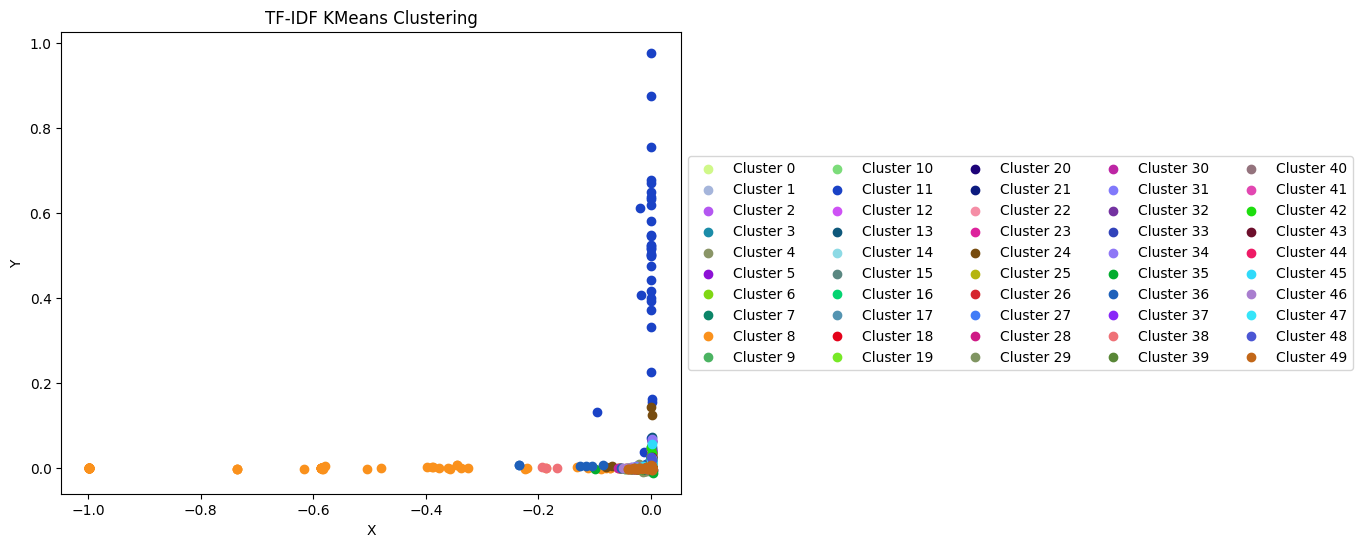

In [ ]:
# Create a scatter plot
scatter_cluster(pca_pd, 50, 5)

# Games clustered on short_description
In this section the anlaysis made on the best clustering model on the texts contained in the column *short_description* is presented

In [ ]:
# Load the data
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
# Pre-Process the data
tf_idf_short_df = process_data_for_clustering(games_df, 'short_description')

In [ ]:
# Normalize the features to compute cosine similarity
tf_idf_short_df = Normalizer(inputCol='features', outputCol='features_norm', p=1).transform(tf_idf_short_df)

The best fitted model is then loaded.

It is important to notice that it has been decided to use the model with K=300 since, as it can be saw from the table below, is the one that provided the best results.

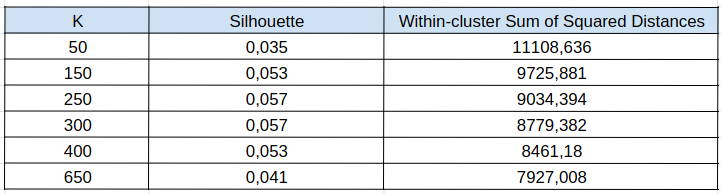

Also in this case it can be saw, from the silhouette value, that the model did not perform too well, since the clusters are overlapping.

Additionally, by comparing this results with the one obtained in the clustering of the *about_the_game* texts it can be seen that, with the same configuration, the clustering over the other texts performs better, so it is possible to suppose that other configuration of the clustering over the other type of texts would lead to berter results

In [ ]:
# Load the best fitted model
cluster_short = KMeansModel.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/models/KMEANS_short_K_300')

In [ ]:
# Create the mapping between entries and clusters
clusters_short_df = cluster_short.transform(tf_idf_short_df)

In [ ]:
# In order to try to free some RAM
del games_df
gc.collect()

480

In [ ]:
shilouette = evaluate_k_means(clusters_short_df)
print('The shilouette score, computed with the cosine distance, is: {:.3f}'.format(shilouette))

The shilouette score, computed with the cosine distance, is: 0.057


In [ ]:
# Inspect the distribution of the items in a sample of clusters
clusters_short_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|   33|
|      1|   58|
|      2|   25|
|      3|   78|
|      4|   59|
|      5|   24|
|      6|   37|
|      7|   70|
|      8|   48|
|      9|  116|
|     10|   48|
|     11|   71|
|     12|   58|
|     13|   52|
|     14|   38|
|     15|   65|
|     16|  108|
|     17|  136|
|     18|   46|
|     19|   62|
+-------+-----+
only showing top 20 rows



In [ ]:
pca_df = compute_PCA(clusters_short_df)

In [ ]:
pca_pd = pca_df.toPandas()

As anticipated from the silhouette metrics the clusters are ovelapping

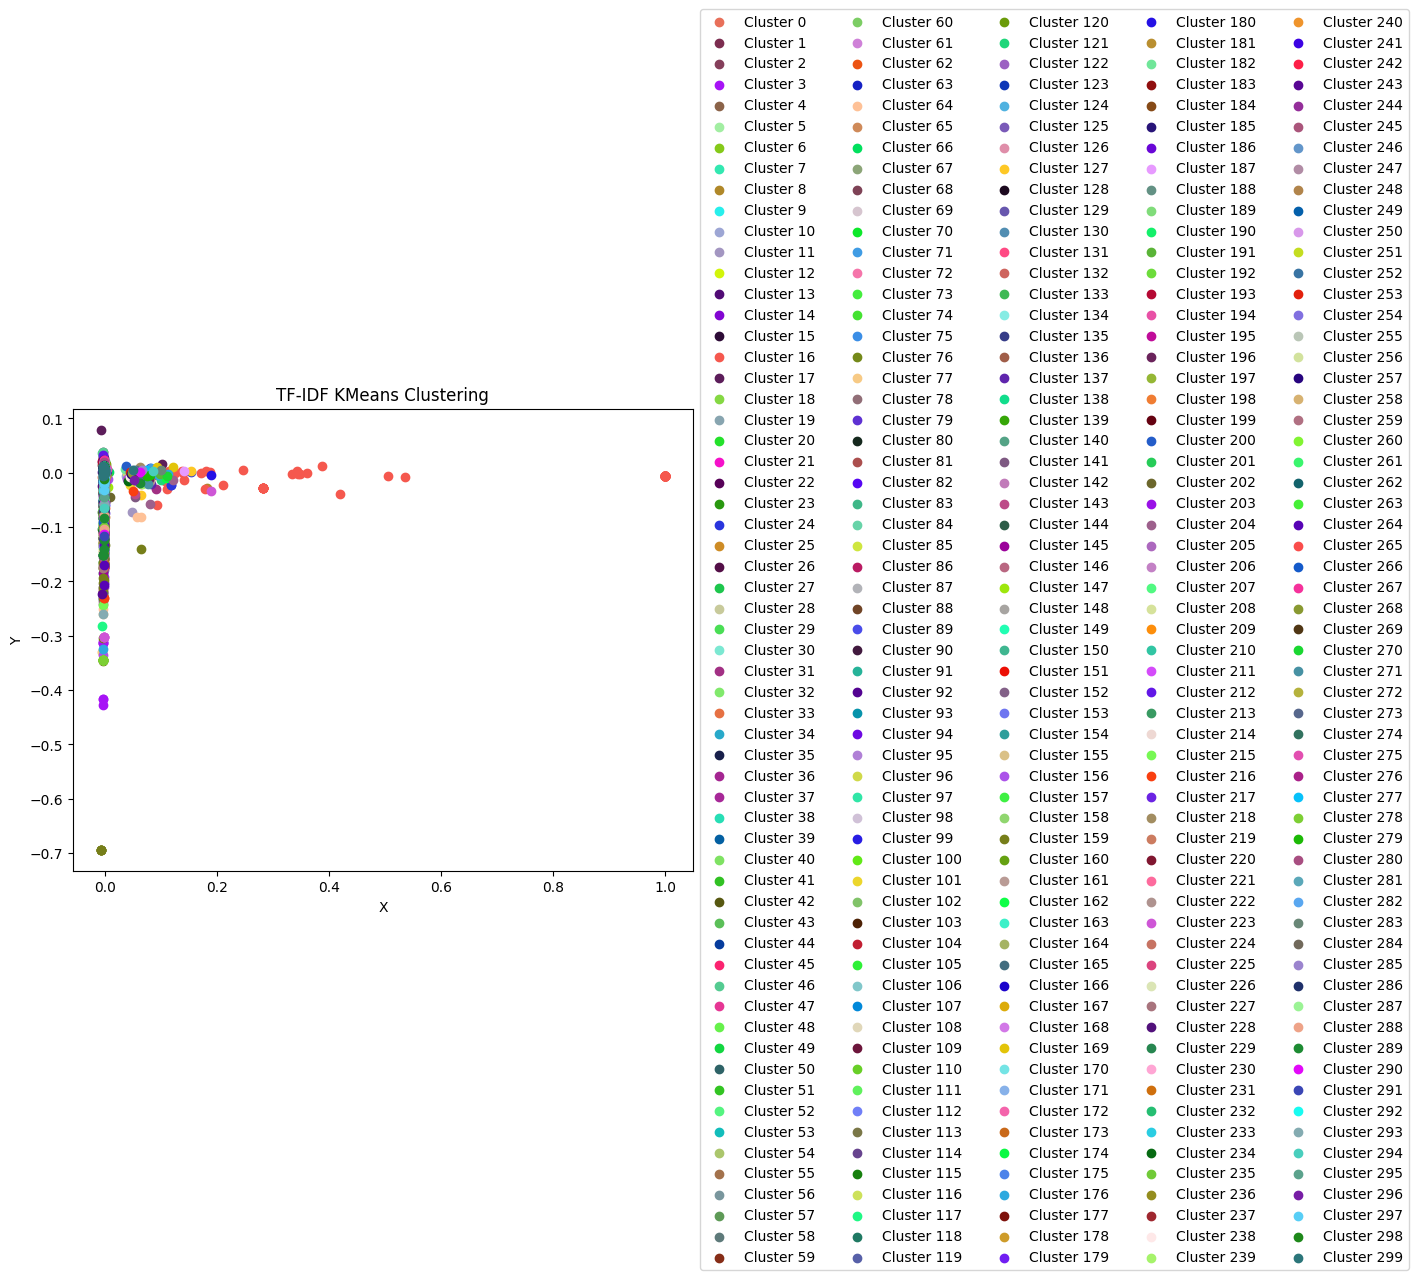

In [ ]:
# Create a scatter plot
scatter_cluster(pca_pd, 300, 5)

# Create Demo Dataset
In order to make the execution of the web application as light as possible it has been decided to use only a little sample of the data.

Specifically it will be possible to get simlar games over the plot only for 100 of the more or less 15000 games present in the original dataset

In [ ]:
# Load the data
games_df = spark.read.load('/content/gdrive/MyDrive/VideogameRecommenderSystem/games.csv',
                           format="csv",
                           sep=",",
                           inferSchema="true",
                           header="true")

In [ ]:
g_tmp = games_df.where(games_df.total_recommendations > 0)

In [ ]:
top_100_distinct_values = g_tmp.groupBy('steam_appid').count().orderBy(sqlf.col("count").desc()).limit(100)

In [ ]:
demo_game_df = g_tmp.join(top_100_distinct_values, on='steam_appid', how="inner")

In [ ]:
demo_game_df.write.options(header='True', delimiter=',').csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/demo_game_cluster_data')

# Create Demo Clusters
In order to provide recommendations also about the plot of the games, it has been decided to use the clustering model that gives the bes overall performances (the one that performs the cluster over *short_description* with K=300).

In order to avoid all the data pre-processing and the model application to data it has been decided to save the dataframe with the mapping of the entries and clusters so that it could be used later directly

In [ ]:
# Inspect the resulting dataframe schema in order to drop unuseful informations
clusters_short_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- total_recommendations: integer (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- terms: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- terms_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- cluster: integer (nullable = false)



In [ ]:
demo_cluster = clusters_short_df.drop('about_the_game', 'total_recommendations', 'tokens', 'terms', 'terms_stemmed', 'tf_features', 'features', 'features_norm')

In [ ]:
demo_cluster.printSchema()

root
 |-- name: string (nullable = true)
 |-- steam_appid: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- cluster: integer (nullable = false)



In [ ]:
demo_cluster.write.options(header='True', delimiter=',').csv('/content/gdrive/MyDrive/VideogameRecommenderSystem/demo_cluster')